In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data Management
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
from ta import add_all_ta_features

from statsmodels.tsa.stattools import adfuller

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

import matplotlib.pyplot as plt

In [3]:
start_date = "2017-01-01"
end_date = "2022-06-01"
symbol = "^VIX" # Vol of S&P 500

yf.pdr_override()
# df = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
df = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,14.07,14.07,12.85,12.85,12.85,0
2017-01-04,12.78,12.80,11.63,11.85,11.85,0
2017-01-05,11.96,12.09,11.40,11.67,11.67,0
2017-01-06,11.70,11.74,10.98,11.32,11.32,0
2017-01-09,11.71,12.08,11.46,11.56,11.56,0


In [4]:
# Add TA
df = add_all_ta_features(df, open="Open", high="High", low = "Low", close="Adj Close", volume="Volume", fillna=True)
df

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,...,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,14.070000,14.070000,12.850000,12.850000,12.850000,0,-0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1000.0,12.850000,12.850000,12.850000,0.000000,0.000000,0.0,0.0,13.256667,14.476666,12.036668,18.405823,0.333333,0.0,0.0,12.850000,14.070000,13.460,9.494158,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,13.460000,13.460000,13.460000,13.460,0.000000,0.000000,0.000000,0.000000,0.000000,20.470470,22.233120,4.0,4.0,0.0,10.94000,14.070000,0.0,0.0,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,12.850000,-32.349937,0.000000,0.000000
2017-01-04,12.780000,12.800000,11.630000,11.850000,11.850000,0,-0.0,0,0.0,-0.0,0.0,0.0,-0.0,0.0,50.0,1000.0,12.350000,13.350000,11.350000,16.194331,0.250000,0.0,0.0,12.675000,13.870000,11.480000,18.856011,0.154812,0.0,0.0,11.630000,14.070000,12.850,19.757081,0.090164,0.000000,0.000000,-0.079772,-0.015954,-0.063818,...,-13.161491,12.850000,12.850000,12.850000,12.850,0.000000,0.000000,0.000000,0.000000,-66.666667,20.470470,22.233120,4.0,8.0,-4.0,10.94000,14.070000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-100.000000,9.016406,9.016406,4.508203,-90.983594,0.000000,0.000000,-0.624394,-0.124879,-0.499515,0.0,0.0,0.0,12.098375,-7.782101,-8.101594,-7.782101
2017-01-05,11.960000,12.090000,11.400000,11.670000,11.670000,0,-0.0,0,0.0,-0.0,0.0,0.0,-0.0,0.0,50.0,1000.0,12.123334,13.161452,11.085215,17.125952,0.281656,0.0,0.0,12.356667,13.383333,11.330000,16.617210,0.165584,0.0,0.0,11.400000,14.070000,12.735,22.023646,0.101124,0.000000,0.000000,-0.155721,-0.043908,-0.111814,...,-16.729720,12.735000,12.735000,12.735000,12.735,0.000000,0.000000,0.000000,0.000000,-70.740755,20.470470,22.233120,4.0,12.0,-8.0,10.94000,14.070000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-100.000000,15.654975,10.112376,6.376261,-89.887624,0.000000,0.000000,-1.226732,-0.345249,-0.881483,0.0,0.0,0.0,11.825780,-1.518990,-1.530645,-9.182881
2017-01-06,11.700000,11.740000,10.980000,11.320000,11.320000,0,-0.0,0,0.0,-0.0,0.0,0.0,-0.0,0.0,50.0,1000.0,11.922500,13.059283,10.785717,19.069543,0.234998,0.0,0.0,12.104167,13.064167,11.144167,15.862307,0.091580,0.0,0.0,10.980000,14.070000,12.525,25.917384,0.110032,0.000000,0.000000,-0.241372,-0.083401,-0.157971,...,-20.477094,12.525000,12.525000,12.525000,12.525,0.000000,0.000000,0.000000,0.000000,-87.635601,20.470470,22.233120,4.0,16.0,-12.0,10.94000,14.016600,0.0,0.0,0.000000,0.000000,0.000000,0.000000,-100.000000,21.336782,11.003241,10.044008,-88.996759,0.000000,0.000000,-1.916831,-0.659566,-1.257265,0.0,0.0,0.0,11.503803,-2.999146,-3.045041,-11.906620
2017-01-09,11.710000,12.080000,11.460000,11.560000,11.560000,0,-0.0,0,0.0,-0.0,0.0,0.0,0.0,0.0,50.0,1000.0,11.850000,

### Data Preprocessing - Stationarity

In [5]:
# Identify non-stationary column
non_stationaries = []
for col in df.columns:
    dftest = adfuller(df[col].values)
    p_value = dftest[1]
    t_test  = dftest[0] < dftest[4]['1%']
    if p_value > 0.05 or not t_test:
        non_stationaries.append(col)
        
print(f"Non-Stationary Features Found: {len(non_stationaries)}")
    

Non-Stationary Features Found: 29


In [6]:
# Convert non-stationaries to stationary
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [7]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

In [8]:
# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

,Open,High,Low,Close,Adj Close,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-04,12.78,12.80,-0.094942,11.85,11.85,0.0,0.0,12.350000,0.038911,-0.116732,16.194331,0.250000,0.0,0.0,12.675000,13.870000,-0.046248,18.856011,0.154812,0.0,0.0,-0.094942,14.07,-0.045319,19.757081,0.090164,0.0,0.0,-0.079772,-0.015954,-0.063818,-0.038911,-0.038911,12.696154,-0.005765,0.006789,0.331305,-0.324516,-0.015199,1.993432,6.644809,-349.822348,-336.660858,-13.161491,12.850,-0.045319,-0.045319,-0.045319,0.0,0.0,0.0,0.0,-66.666667,20.47047,0.0,4.0,8.0,-4.0,0.0,14.070000,0.0,0.0,0.000000,0.0,0.0,0.0,-100.000000,9.016406,9.016406,4.508203,-90.983594,0.000000,0.0,-0.624394,-0.124879,-0.499515,-0.058492,-7.782101,-8.101594,-7.782101
2017-01-05,11.96,12.09,-0.019776,11.67,11.67,0.0,0.0,12.123334,-0.014123,-0.023329,17.125952,0.281656,0.0,0.0,12.356667,13.383333,-0.013066,16.617210,0.165584,0.0,0.0,-0.019776,14.07,-0.008949,22.023646,0.101124,0.0,0.0,-0.155721,-0.043908,-0.111814,-0.018354,-0.018354,12.538284,-0.006412,0.063316,0.476734,-0.413418,-0.042641,2.918491,6.871475,-361.755438,-345.025718,-16.729720,12.735,-0.008949,-0.008949,-0.008949,0.0,0.0,0.0,0.0,-70.740755,20.47047,0.0,4.0,12.0,-8.0,0.0,14.070000,0.0,1.0,0.000000,0.0,0.0,0.0,-100.000000,15.654975,10.112376,6.376261,-89.887624,0.000000,0.0,-1.226732,-0.345249,-0.881483,-0.022532,-1.518990,-1.530645,-9.182881
2017-01-06,11.70,11.74,-0.036842,11.32,11.32,0.0,0.0,11.922500,-0.007763,-0.027018,19.069543,0.234998,0.0,0.0,12.104167,13.064167,-0.016402,15.862307,0.091580,0.0,0.0,-0.036842,14.07,-0.016490,25.917384,0.110032,0.0,0.0,-0.241372,-0.083401,-0.157971,-0.016566,-0.016566,12.350856,-0.008018,0.096429,0.561555,-0.465126,-0.082371,3.809335,7.072309,-372.328510,-351.851416,-20.477094,12.525,-0.016490,-0.016490,-0.016490,0.0,0.0,0.0,0.0,-87.635601,20.47047,0.0,4.0,16.0,-12.0,0.0,14.016600,0.0,0.0,0.000000,0.0,0.0,0.0,-100.000000,21.336782,11.003241,10.044008,-88.996759,0.000000,0.0,-1.916831,-0.659566,-1.257265,-0.027227,-2.999146,-3.045041,-11.906620
2017-01-09,11.71,12.08,0.043716,11.56,11.56,0.0,0.0,11.850000,-0.011637,0.000646,17.845024,0.362861,0.0,0.0,12.023333,12.915333,-0.001152,14.837815,0.240284,0.0,0.0,0.000000,14.07,0.000000,26.075950,0.187703,0.0,0.0,-0.286580,-0.124037,-0.162544,-0.006081,-0.006081,12.229186,-0.006072,0.203659,0.546225,-0.342566,-0.124884,4.659285,7.144809,-376.145339,-356.710201,-19.435139,12.525,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-41.346950,20.47047,0.0,4.0,16.0,-12.0,0.0,13.895136,0.0,0.0,15.780578,0.0,0.0,0.0,-99.449116,23.010784,18.770254,13.295290,-81.229746,0.000000,0.0,-2.289756,-0.985604,-1.304152,0.002666,2.120148,2.097985,-10.038910
2017-01-10,11.59,11.79,-0.013089,11.49,11.49,0.0,0.0,11.790000,-0.008950,-0.000415,16.994041,0.350269,0.0,0.0,11.941111,12.764444

### Data preprocessing - Scalling and Target Setting

In [9]:
# Set Target ( for Supervised ML later on)
df_stationary["TARGET"] = -1
df_stationary.loc[df_stationary["Adj Close"].shift(-1) > df_stationary["Adj Close"], "TARGET"] = 1

In [10]:
# Split Target from Features Set
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [11]:
# Feature Scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)


In [13]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=42)

# Unsupervised Learning - PCA dimension Reduction

In [30]:
# PCA
n_components = 8
pca = PCA(n_components=n_components)
pca_result = pca.fit(X_train)
X_train_pca = pca_result.transform(X_train)
X_test_pca = pca_result.transform(X_test)

In [31]:
print("Variance of each componet: ", pca.explained_variance_ratio_)
print("\n Total Variance Explained: ", round(sum(list(pca.explained_variance_ratio_))* 100, 2) ) 


Variance of each componet:  [0.3935497  0.19222962 0.08524114 0.04806597 0.03274076 0.02497421
 0.02380088 0.0207912 ]

 Total Variance Explained:  82.14


In [32]:
# Create Columns
pca_cols = []
for i in range(n_components):
    pca_cols.append(f"PC_{i}")

In [33]:
# Create and View DataFrame
df_pca = pd.DataFrame(data=X_train_pca,columns = pca_cols)
df_pca.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
0,-7.463563,0.387121,0.688559,0.060511,4.297519,0.550680,-2.679810,7.567345
1,-4.710161,-0.436166,2.592168,0.695664,0.989058,0.896053,-0.093612,0.936837
2,-1.760442,4.576496,1.214752,0.708146,0.776972,0.505086,-1.958881,-0.310549
3,1.964753,-4.887447,0.567331,0.906469,-1.686621,-0.877631,0.224014,0.639620
4,-4.715084,1.132281,-2.518685,-0.778369,1.896506,0.955992,0.386073,-0.710501


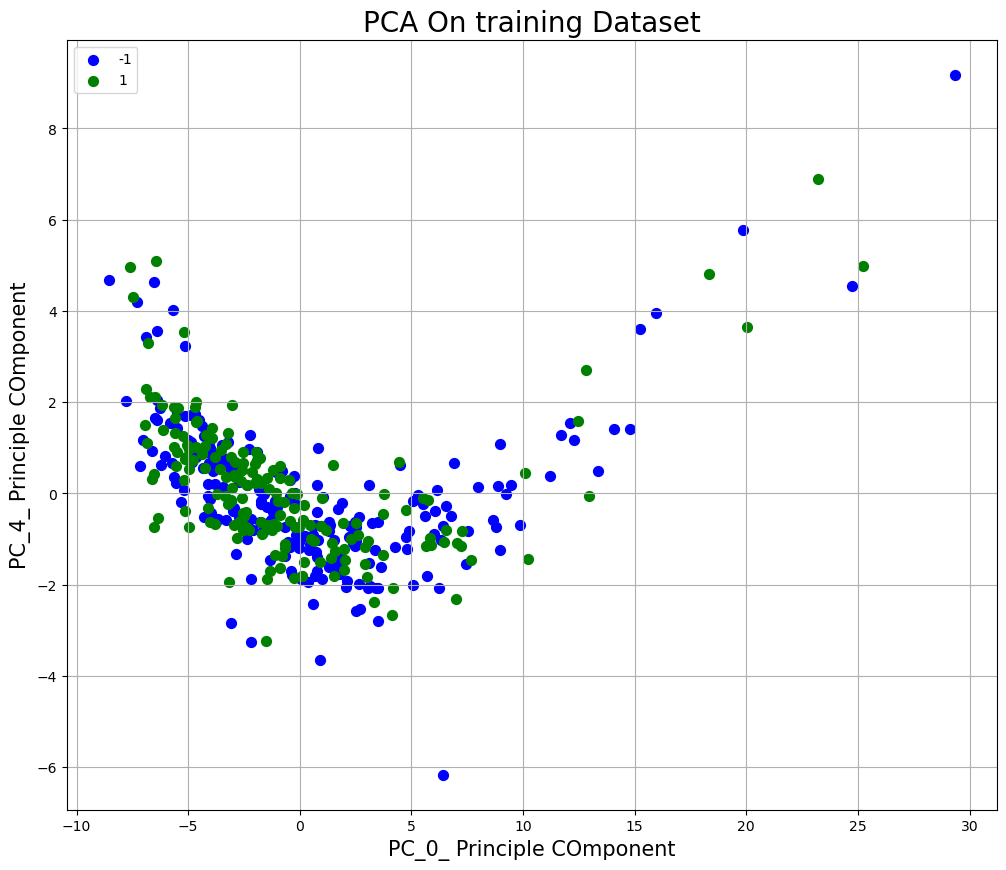

In [34]:
# Visualize Principle Components with Scatter Plt
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
col_1 = "PC_0"
col_2 = "PC_4"
ax.set_xlabel(f"{col_1}_ Principle COmponent", fontsize = 15)
ax.set_ylabel(f"{col_2}_ Principle COmponent", fontsize = 15)
ax.set_title("PCA On training Dataset", fontsize=20)

targets = [-1, 1]

colors = ['b', 'g']

for target, color in zip(targets, colors):
    indices_to_keep = y_train == target
    indices_to_keep = list(indices_to_keep)
    ax.scatter(df_pca.loc[indices_to_keep, col_1], 
               df_pca.loc[indices_to_keep, col_2], 
               c = color,
               s = 50)
    
ax.legend(targets)
ax.grid()
    



In [35]:
### Supervised ML _ Random Forest Classification

In [41]:
classifier = RandomForestClassifier(n_estimators=12, max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")


Test Accuracy: 0.565582371458552
Test Precision: 0.5308056872037915


In [43]:
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba

array([[0.3887724 , 0.6112276 ],
       [0.6426075 , 0.3573925 ],
       [0.49879013, 0.50120987],
       ...,
       [0.52807215, 0.47192785],
       [0.51966603, 0.48033397],
       [0.54058288, 0.45941712]])

In [45]:
train_scores, test_scores = list(), list()
values = [i for i in range(1, 200)]
for i in values:
    classifier = RandomForestClassifier(n_estimators=i, max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Training Data
    y_train_pred = classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    train_scores.append(accuracy_train)
    
    y_test_pred = classifier.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    test_scores.append(accuracy_test)
    
    

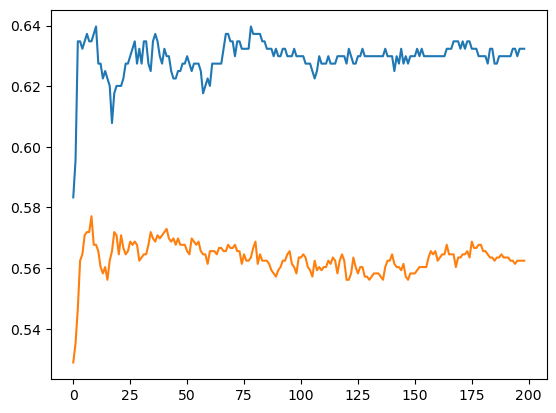

In [46]:
# Plot Results
plt.plot(train_scores)
plt.plot(test_scores)


plt.show()